In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import joblib
import ta
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
import matplotlib.pyplot as plt
import datetime

In [3]:
nse_stocks = [
    "RELIANCE.NS",   # Reliance Industries Limited
    "TCS.NS",        # Tata Consultancy Services
    "HDFCBANK.NS",   # HDFC Bank Limited
    "INFY.NS",       # Infosys Limited
    "ICICIBANK.NS",  # ICICI Bank Limited
    "KOTAKBANK.NS",  # Kotak Mahindra Bank Limited
    "HINDUNILVR.NS", # Hindustan Unilever Limited
    "LT.NS",         # Larsen & Toubro Limited
    "SBIN.NS",       # State Bank of India
    "BHARTIARTL.NS", # Bharti Airtel Limited
    "ITC.NS",        # ITC Limited
    "BAJFINANCE.NS", # Bajaj Finance Limited
    "AXISBANK.NS",   # Axis Bank Limited
    "HCLTECH.NS",    # HCL Technologies Limited
    "MARUTI.NS",     # Maruti Suzuki India Limited
    "M&M.NS",        # Mahindra & Mahindra Limited
    "ASIANPAINT.NS", # Asian Paints Limited
    "NESTLEIND.NS",  # Nestlé India Limited
    "ULTRACEMCO.NS", # UltraTech Cement Limited
    "SUNPHARMA.NS",  # Sun Pharmaceutical Industries Limited
    "TITAN.NS",      # Titan Company Limited
    "DRREDDY.NS",    # Dr. Reddy's Laboratories Limited
    "WIPRO.NS",      # Wipro Limited
    "ADANIPORTS.NS", # Adani Ports and Special Economic Zone Limited
    "POWERGRID.NS",  # Power Grid Corporation of India Limited
    "GRASIM.NS",     # Grasim Industries Limited
    "NTPC.NS",       # NTPC Limited
    "ONGC.NS",       # Oil and Natural Gas Corporation Limited
    "INDUSINDBK.NS", # IndusInd Bank Limited
    "BAJAJFINSV.NS"  # Bajaj Finserv Limited
]

In [4]:
def build_model(units=50, dropout=0.2, learning_rate=0.001, num_features=3):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(30, num_features)),
        Dropout(dropout),
        LSTM(units, return_sequences=False),
        Dropout(dropout),
        Dense(1)  # Predicting next day's Close price
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss='mean_squared_error')
    return model

In [9]:
best_models = joblib.load('best_models_old.pkl')

In [27]:
print("Loaded models for stocks:", best_models.keys())

Loaded models for stocks: dict_keys(['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'ICICIBANK.NS', 'KOTAKBANK.NS', 'HINDUNILVR.NS', 'LT.NS', 'SBIN.NS', 'BHARTIARTL.NS', 'ITC.NS', 'BAJFINANCE.NS', 'AXISBANK.NS', 'HCLTECH.NS', 'MARUTI.NS', 'M&M.NS', 'ASIANPAINT.NS', 'NESTLEIND.NS', 'ULTRACEMCO.NS', 'SUNPHARMA.NS', 'TITAN.NS', 'DRREDDY.NS', 'WIPRO.NS', 'ADANIPORTS.NS', 'POWERGRID.NS', 'GRASIM.NS', 'NTPC.NS', 'ONGC.NS', 'INDUSINDBK.NS', 'BAJAJFINSV.NS'])


In [28]:
reliance_model = best_models.get('RELIANCE.NS')
print("Best model hyperparameters:", reliance_model.get_params())

Best model hyperparameters: {'model': <function build_model at 0x000001E88A578310>, 'build_fn': None, 'warm_start': False, 'random_state': None, 'optimizer': 'rmsprop', 'loss': None, 'metrics': None, 'batch_size': 16, 'validation_batch_size': None, 'verbose': 0, 'callbacks': None, 'validation_split': 0.0, 'shuffle': True, 'run_eagerly': False, 'epochs': 50, 'model__dropout': 0.2, 'model__units': 30}


In [29]:
def fetch_stock_data(ticker, days=60):
    stock = yf.Ticker(ticker)
    df = stock.history(period=f"{days}d")
    if df.empty:
        print(f"Failed to retrieve data for {ticker}.")
        return None

    df = df[['Close']].copy()
    df['SMA'] = df['Close'].rolling(window=14).mean()
    df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

    df.dropna(inplace=True)
    return df

In [30]:
def prepare_lstm_input(df):    
    last_30_days = df[['Close', 'SMA', 'RSI']].values[-30:]
    return np.expand_dims(last_30_days, axis=0)


In [31]:
def update_sma_rsi(df, new_close):
    new_row = pd.DataFrame({'Close': [new_close]})
    df = pd.concat([df, new_row], ignore_index=True)

    if len(df) < 14:
        return df

    df['SMA'] = df['Close'].rolling(window=14).mean()
    df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

    return df

In [32]:
def predict_next_month(ticker, days=30):
    if ticker not in best_models:
        print(f"No trained model found for {ticker}.")
        return None
    
    model = best_models[ticker]

    df = fetch_stock_data(ticker)

    if df is None or len(df) < 30:
        print(f"Not enough data for {ticker}.")
        return None

    predictions = []

    for _ in range(days):
        X_input = prepare_lstm_input(df)
        predicted_price = float(model.predict(X_input))
        predictions.append(predicted_price)
        df = update_sma_rsi(df, predicted_price)

    return predictions


In [33]:
stock_predictions = {}

for ticker in nse_stocks:
    stock_predictions[ticker] = predict_next_month(ticker, days=30)

print("Predictions stored for:", list(stock_predictions.keys()))

Predictions stored for: ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'ICICIBANK.NS', 'KOTAKBANK.NS', 'HINDUNILVR.NS', 'LT.NS', 'SBIN.NS', 'BHARTIARTL.NS', 'ITC.NS', 'BAJFINANCE.NS', 'AXISBANK.NS', 'HCLTECH.NS', 'MARUTI.NS', 'M&M.NS', 'ASIANPAINT.NS', 'NESTLEIND.NS', 'ULTRACEMCO.NS', 'SUNPHARMA.NS', 'TITAN.NS', 'DRREDDY.NS', 'WIPRO.NS', 'ADANIPORTS.NS', 'POWERGRID.NS', 'GRASIM.NS', 'NTPC.NS', 'ONGC.NS', 'INDUSINDBK.NS', 'BAJAJFINSV.NS']


In [34]:
def plot_stock_predictions(ticker, actual_days=60, predicted_days=30):
    df = fetch_stock_data(ticker, days=actual_days)

    if df is None or ticker not in stock_predictions:
        print(f"Skipping {ticker}: Not enough data or no predictions found.")
        return

    actual_dates = df.index[-actual_days:]
    actual_prices = df['Close'].values[-actual_days:]
    predicted_prices = stock_predictions[ticker]

    last_actual_date = actual_dates[-1]
    future_dates = [last_actual_date + datetime.timedelta(days=i+1) for i in range(predicted_days)]

    plt.figure(figsize=(12, 6))
    plt.plot(actual_dates, actual_prices, label="Actual Prices (Last 60 Days)", color="blue", linewidth=2)
    plt.plot(future_dates, predicted_prices, label="Predicted Prices (Next 30 Days)", color="red", linestyle="dashed", linewidth=2)
    plt.xlabel("Date")
    plt.ylabel("Stock Price (₹)")
    plt.title(f"{ticker} - Last {actual_days} Days & Next {predicted_days} Days Forecast")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

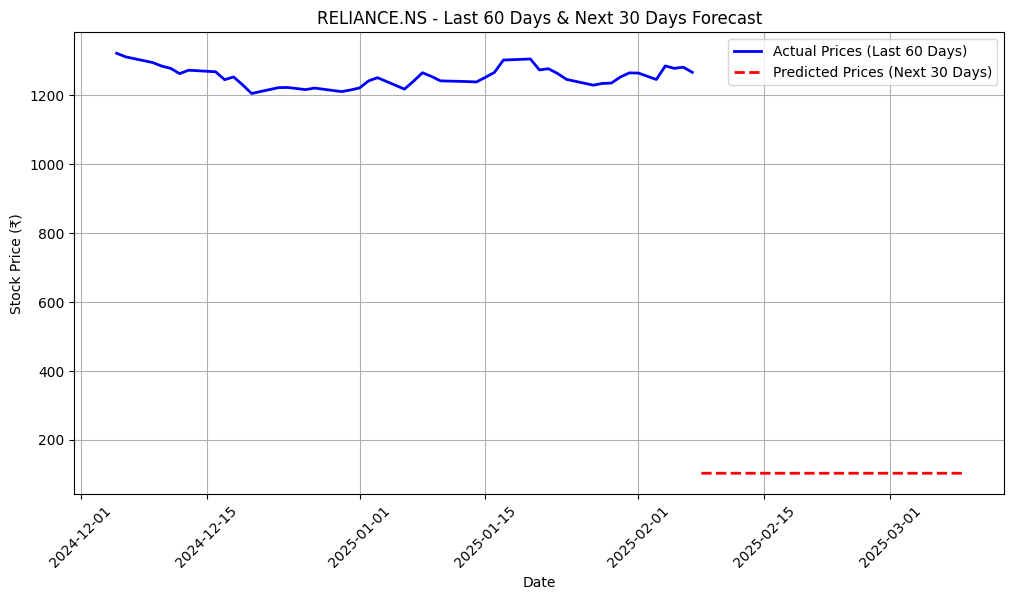

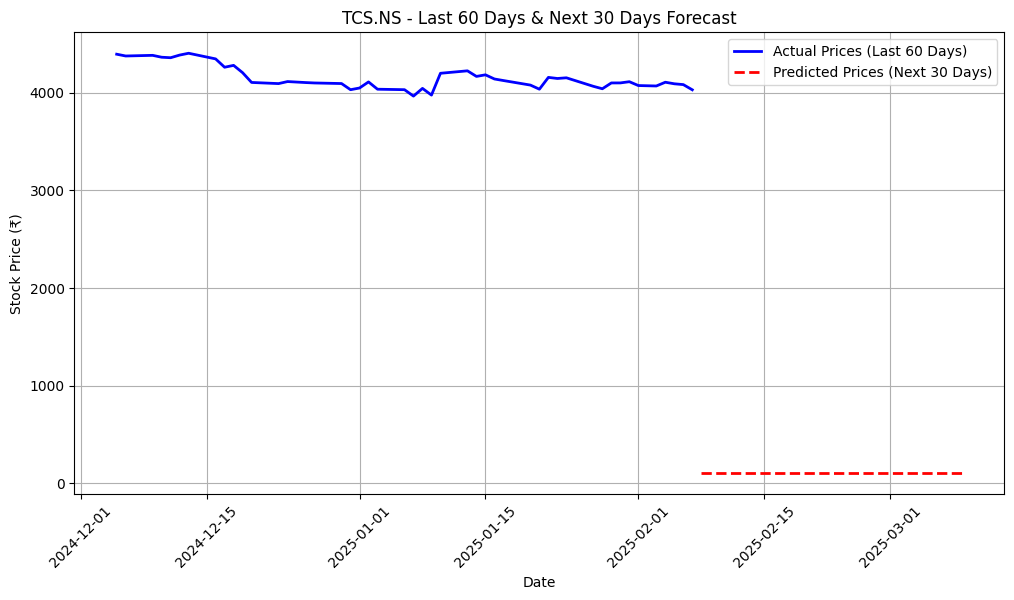

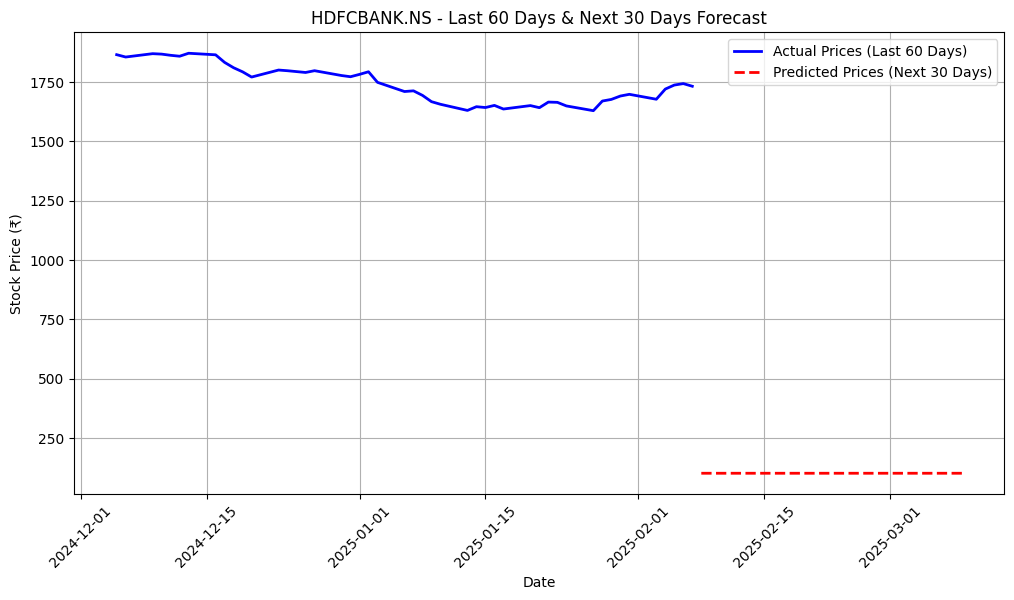

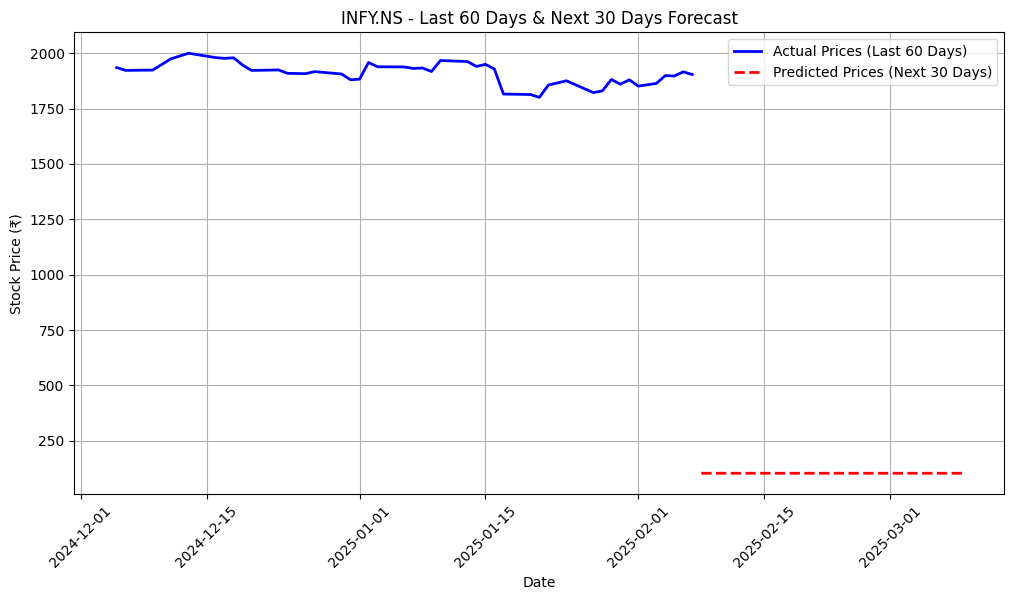

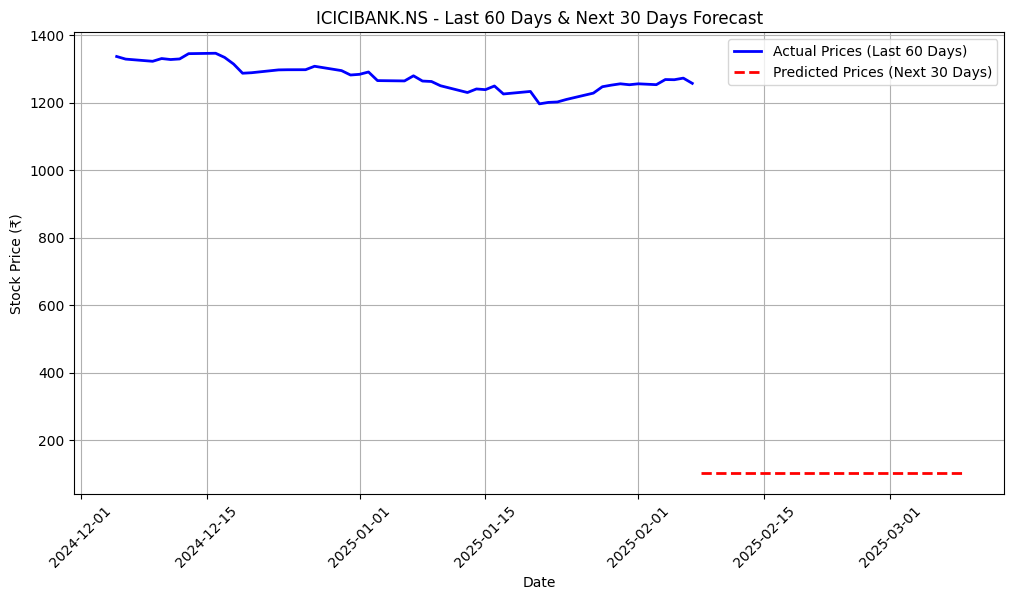

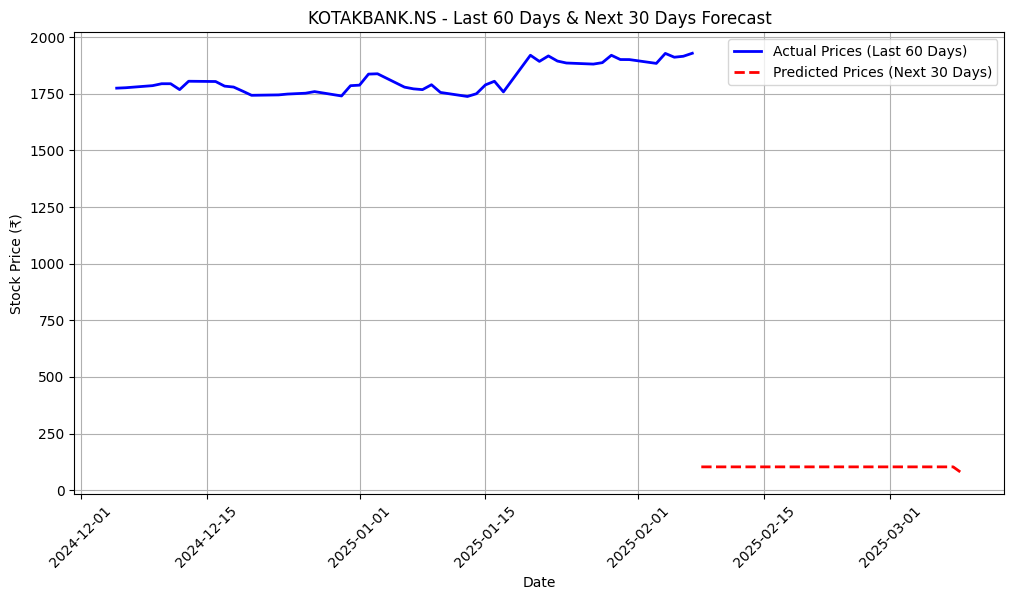

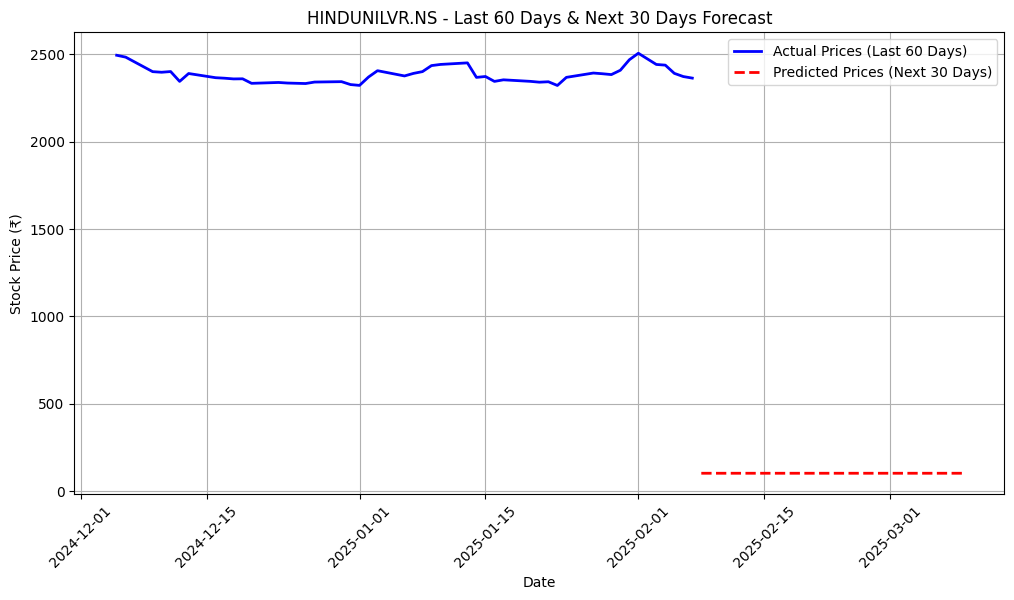

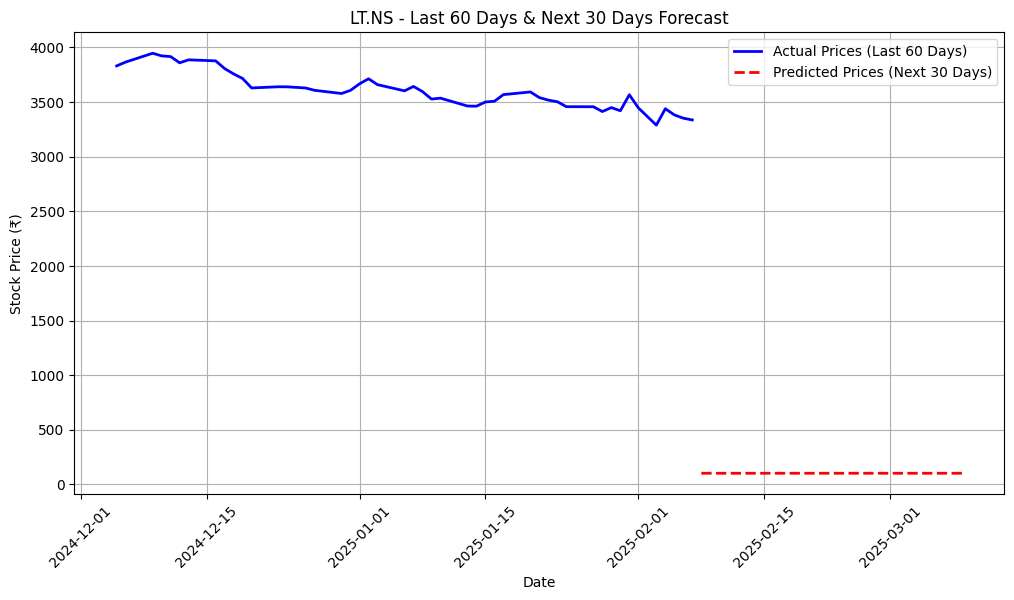

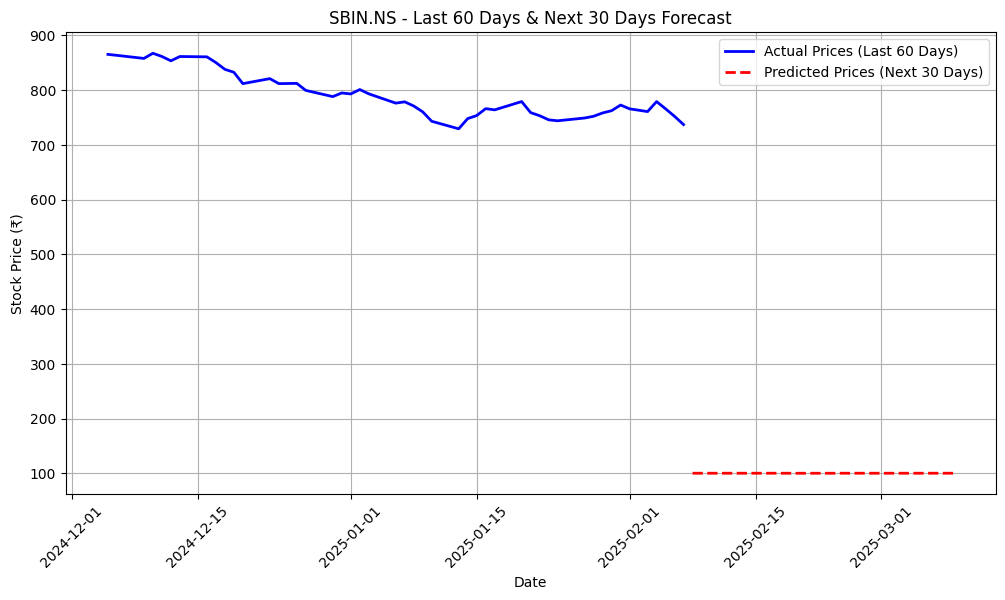

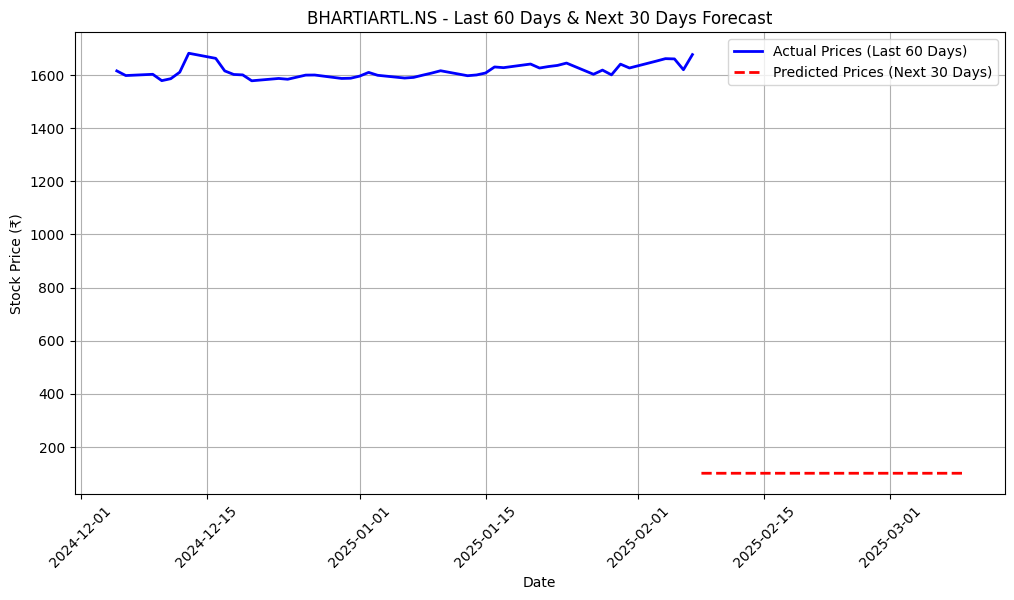

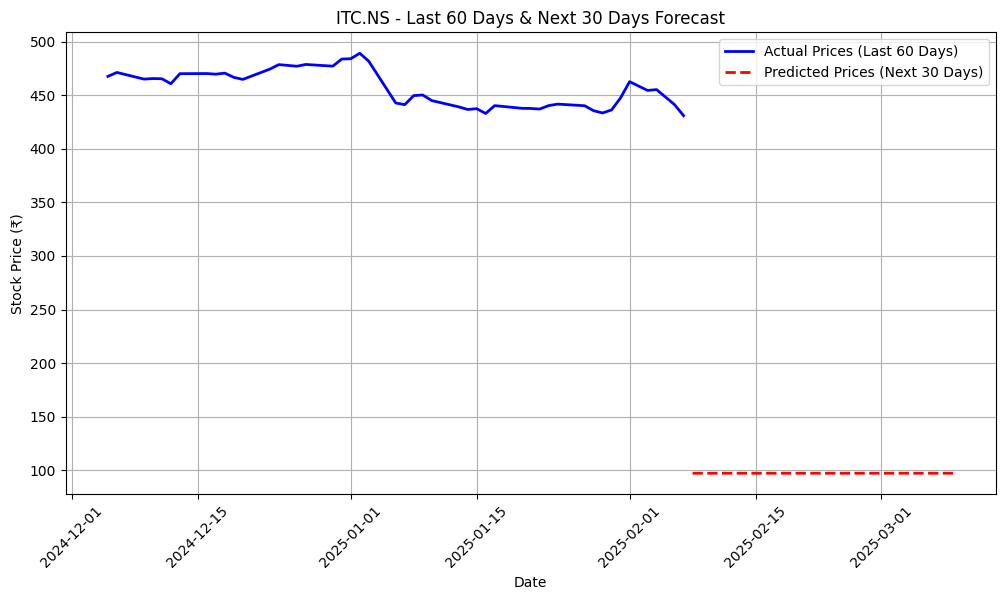

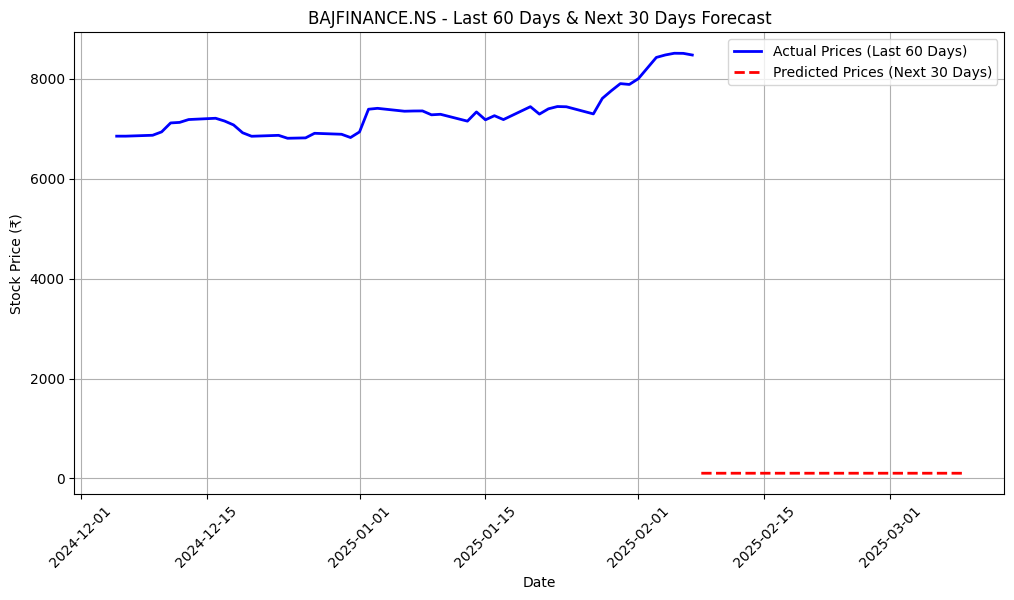

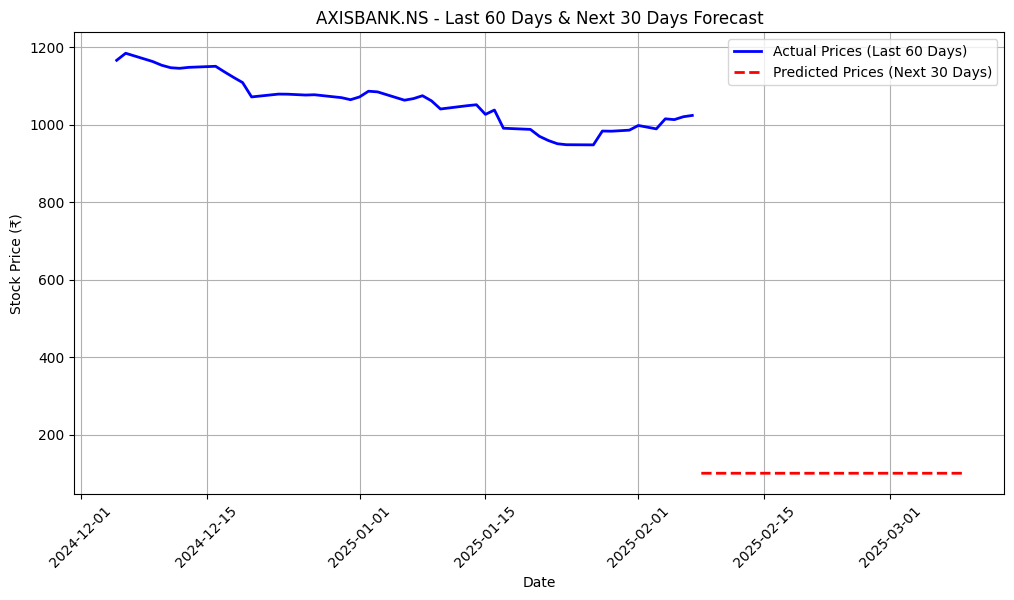

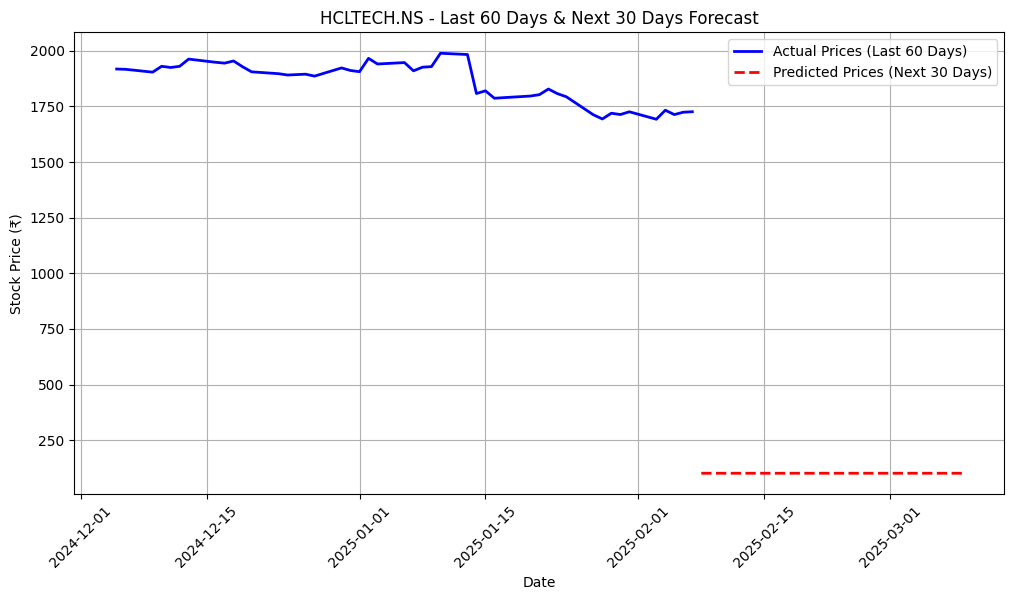

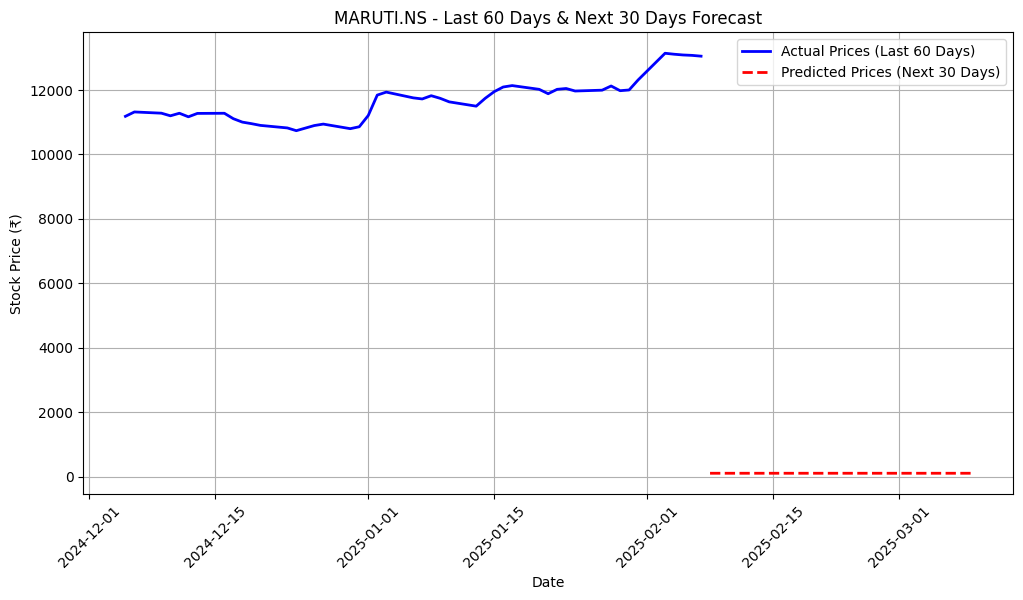

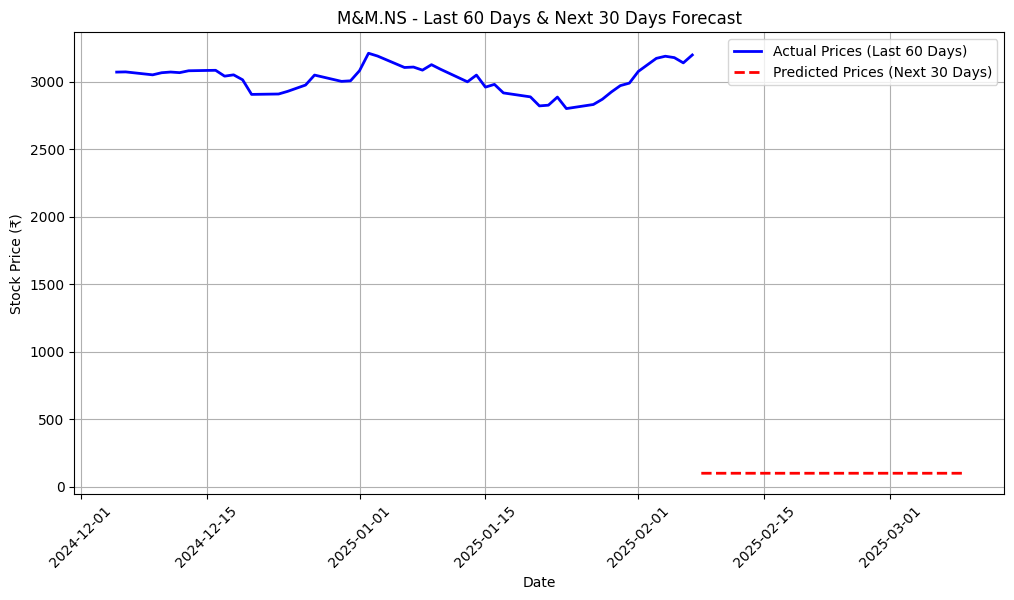

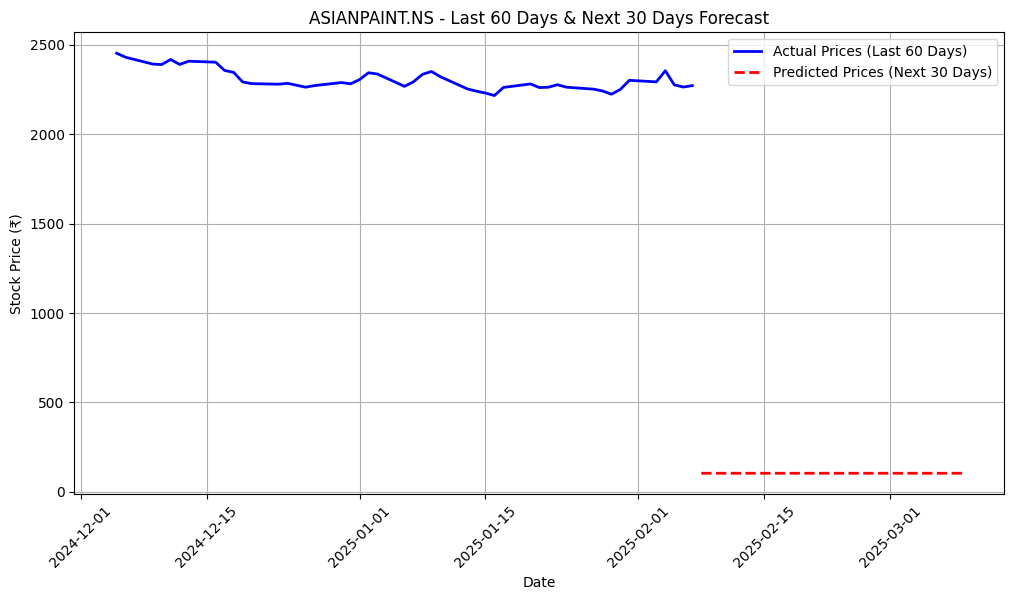

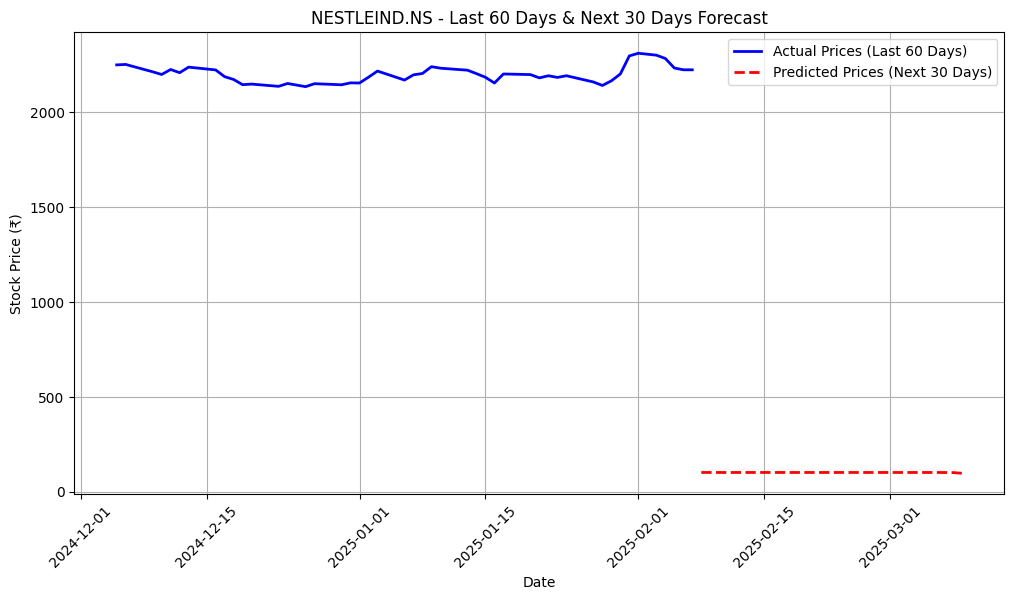

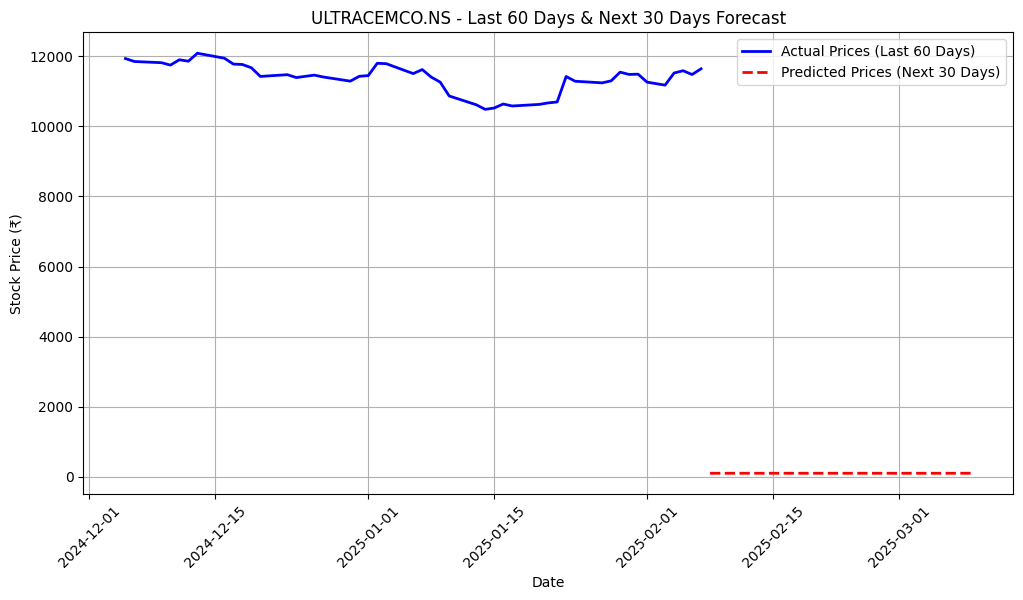

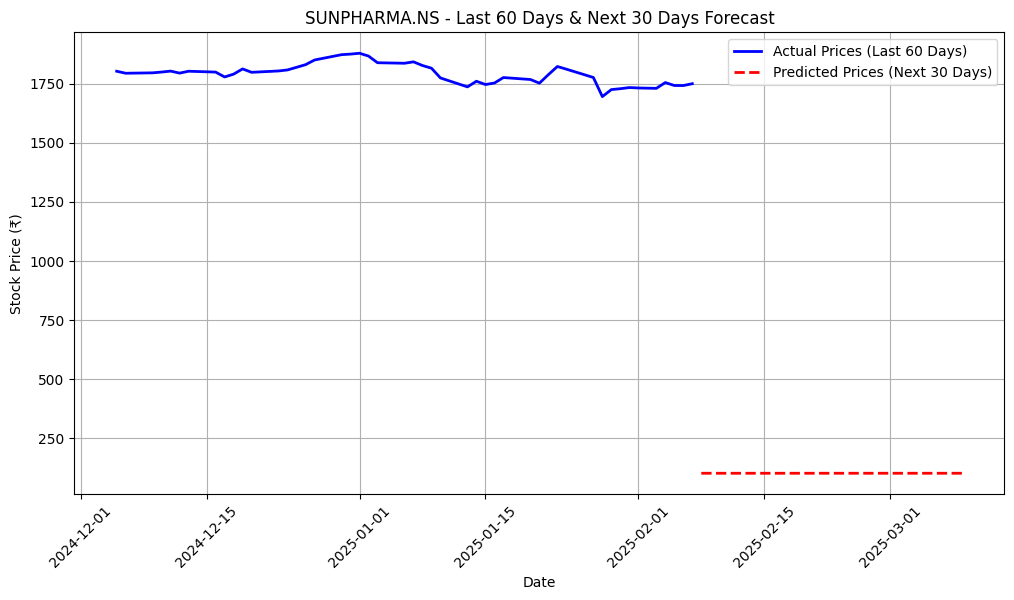

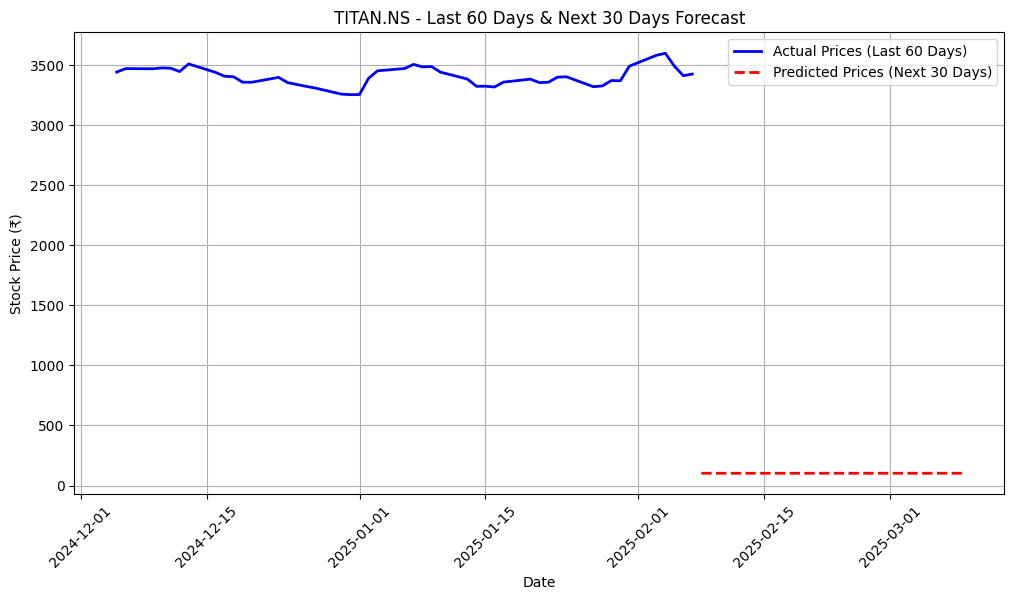

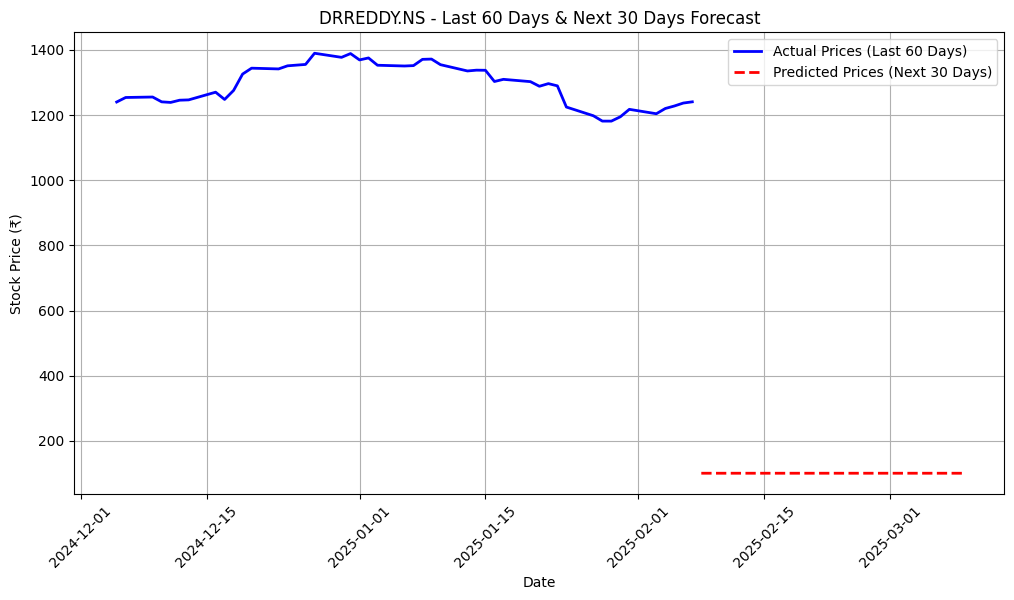

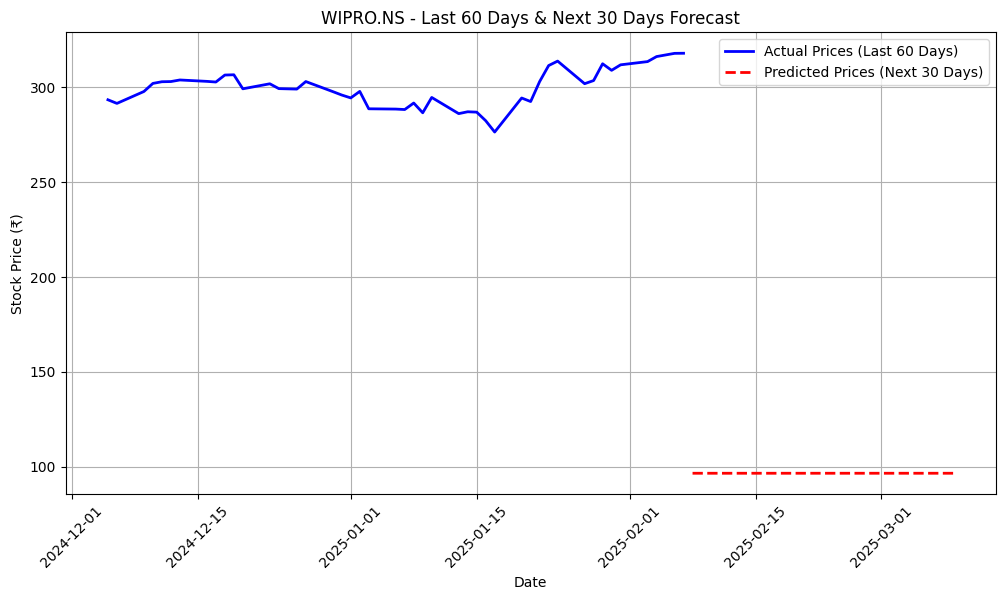

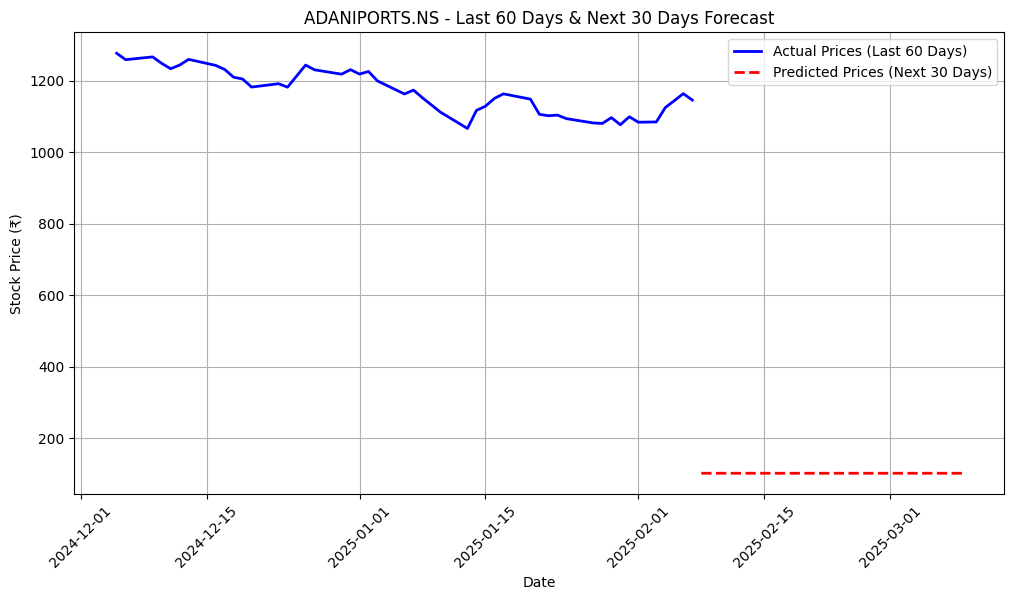

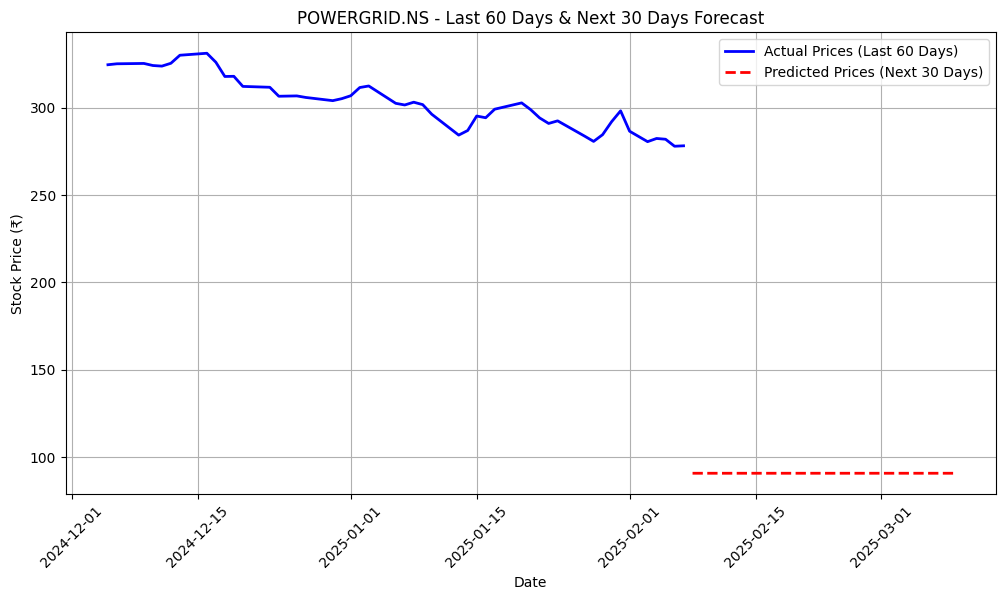

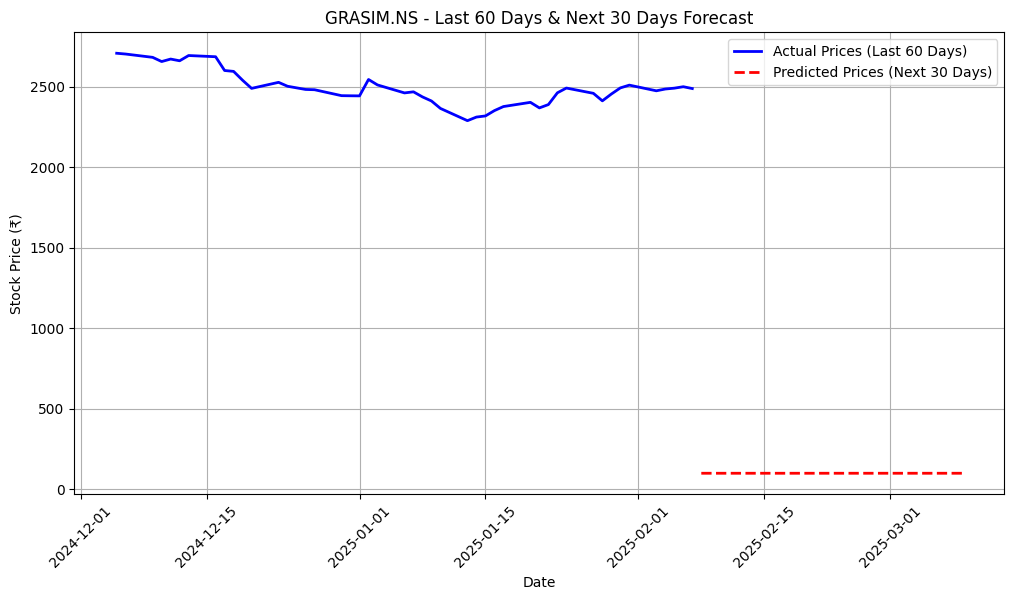

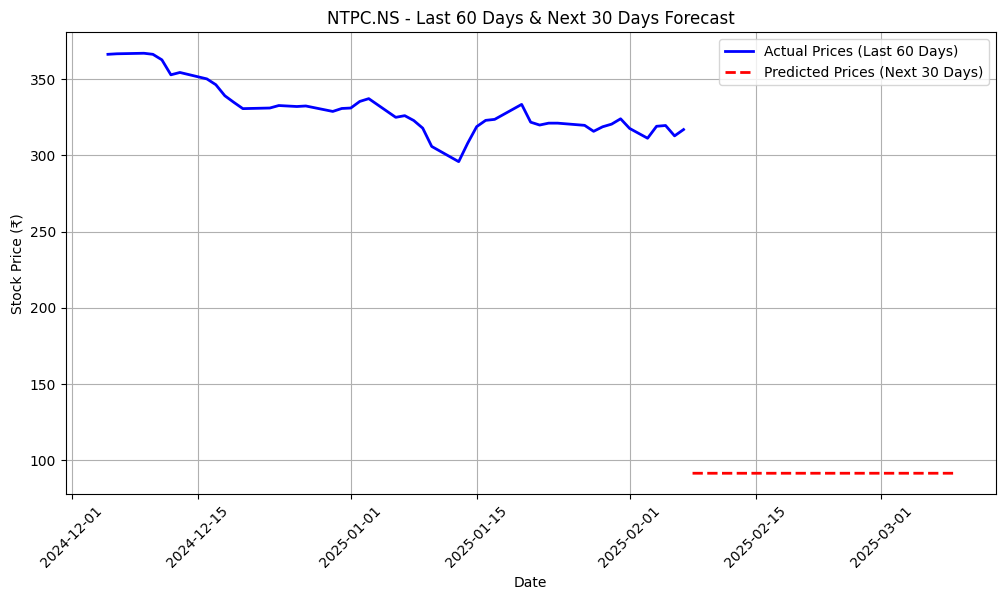

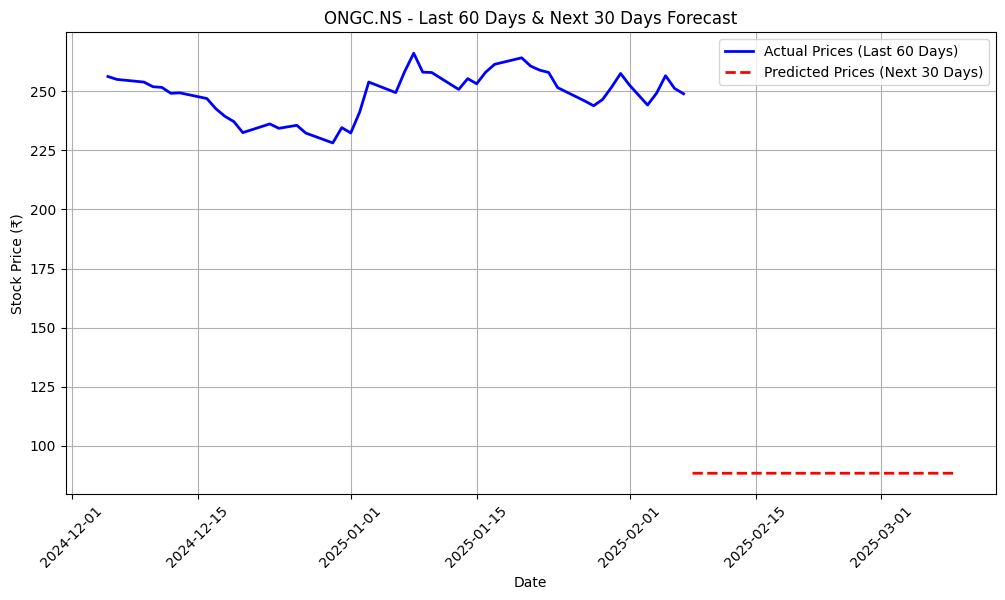

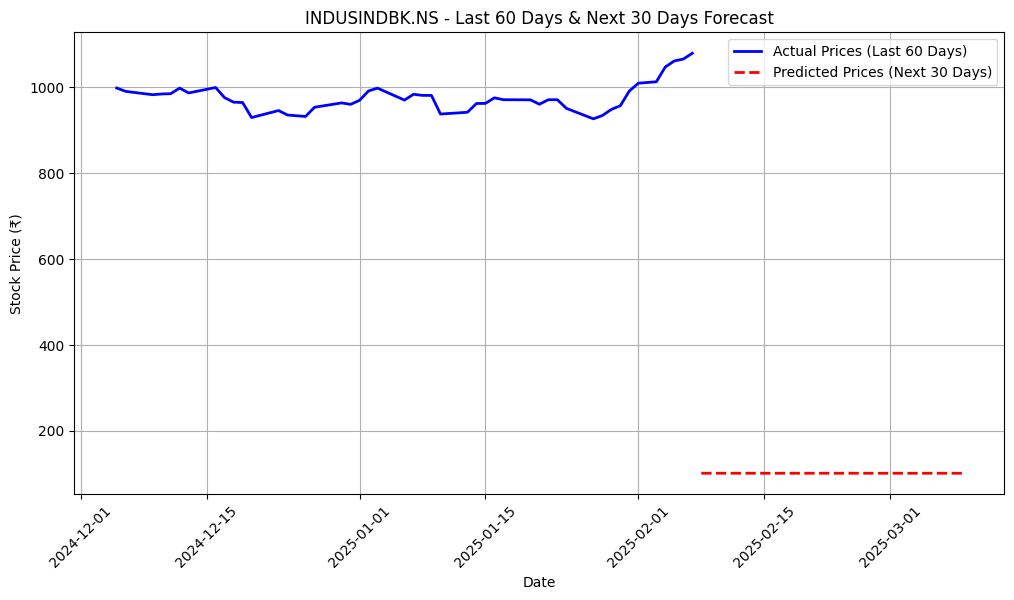

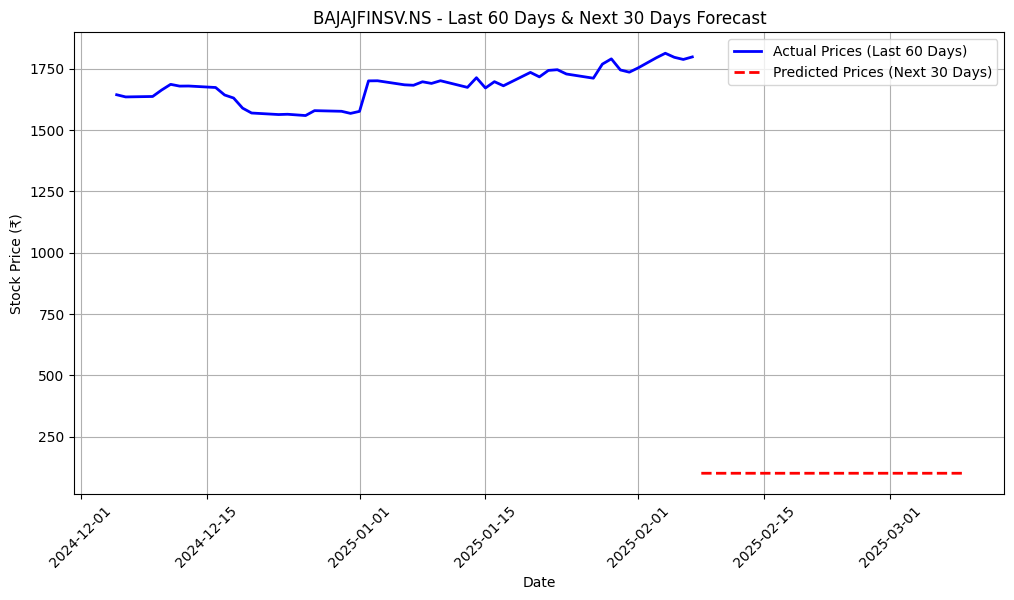

In [35]:
for ticker in nse_stocks:
    plot_stock_predictions(ticker)